# Entanglement and architecture analisys

The main idea to this project is to evaluate the importance of the entanglement of the circuit to incorporate to the architecture analisys.
The following code follow this procedure:

## Calculate the entanglement of the circuit.

We used the concurrence calculation for all the pairs of qubits making a NxN matrix.

Given the following two qubit system:

$$ |\psi\rangle = a|00\rangle + b|01\rangle + c|10\rangle + d|11\rangle $$

THe concurrence can be calculated as follow:

$$ C = | ad-bc | $$

The result is a NxN matrix to take into account the entanglement of the circuit or algorithm.

## Modify the architecture given the entanglement.

With the matrix, we modified the physical architecture for such qubit that has more entanglement between them.

In [1]:
## Import the required libraries
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_coupling_map
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
# Some support functions to calculate the entanglement matrix.

def string2dict(q, len):
    st = ''
    for i in range(0,q+1):
        if i == 0:
            st += '1'
        else:
            st += '0'
    for i in range(0,len-q):
        st = '0'+st
    return st

def string2dict_two(q1 ,q2, len):
    st = ''
    for i in range(0, len):
        if i == q1 or i == q2:
            st = '1' + st
        else:
            st = '0' + st
    return st

def string2dict_zero(len):
    st = ''
    for i in range(0, len):
        st = '0' + st
    return st

In [3]:
# Function to calculate the entanglement matrix.

def general_entanglement(qc, qubit_m1, qubit_m2, shots):

    ent = 0

    qc_aux = qc.copy()

    qc_aux.measure([qubit_m1,qubit_m2],[qubit_m1,qubit_m2])
    Simulation = Aer.get_backend('qasm_simulator')
    Quantum_Transpiler = transpile(qc_aux,Simulation, coupling_map=[[0,1],[1,2],[2,3],[3,4],[4,5]])
    Quantum_Obj = assemble(Quantum_Transpiler, shots=shots)
    Result = Simulation.run(Quantum_Obj).result()

    values_dict = Result.get_counts()

    value_00 = string2dict_zero(qc_aux.num_qubits)
    value_01 = string2dict(qubit_m1, qc_aux.num_qubits-1)
    value_10 = string2dict(qubit_m2, qc_aux.num_qubits-1)
    value_11 = string2dict_two(qubit_m1, qubit_m2, qc_aux.num_qubits)

    values_dict.setdefault(value_00, 0)
    values_dict.setdefault(value_01, 0)
    values_dict.setdefault(value_10, 0)
    values_dict.setdefault(value_11, 0)

    v_00 = np.sqrt(values_dict[value_00]/shots)
    v_01 = np.sqrt(values_dict[value_01]/shots)
    v_10 = np.sqrt(values_dict[value_10]/shots)
    v_11 = np.sqrt(values_dict[value_11]/shots)

    ent = 2*np.abs(v_11*v_00-v_01*v_10)

    return ent

In [4]:
# Plot the entanglement matrix.

def ent_matrix(qc, shots):
    matrix = []

    for i in range(0, qc.num_qubits):
        for j in range(0, qc.num_qubits):
            if i == j:
                matrix.append(1)
            else:
                matrix.append(general_entanglement(qc,i,j, shots))

    new_matrix = np.reshape(matrix, (qc.num_qubits, qc.num_qubits))

    return new_matrix

In [5]:
# Support function that calculated the error between the probability distributions

def error(real_dict, test_dict, shots):
    err = 0

    real_list = list(real_dict.keys())
    test_list = list(test_dict.keys())

    for i in range(0, len(real_list)):

        test_dict.setdefault(real_list[i], 0)
        real_dict.setdefault(test_list[i], 0)
    
    real_list = list(real_dict.keys())
    test_list = list(test_dict.keys())

    for k in range(0, len(real_list)):
        
        err += np.abs(test_dict[real_list[k]]-real_dict[real_list[k]])
    
    return err/shots

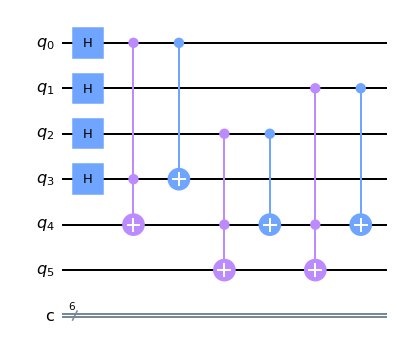

In [6]:
## Circuit definition just a simple one.
## For more information about this circuit, this is the Quantum Full Adder (QFA) for a two qubit system.
## The perfect case.
qc = QuantumCircuit(6,6)

qc.h([0,1,2,3])
qc.ccx(0,3,4)
qc.cnot(0,3)
qc.ccx(2,4,5)
qc.cnot(2,4)
qc.ccx(1,4,5)
qc.cnot(1,4)

qc.draw('mpl')

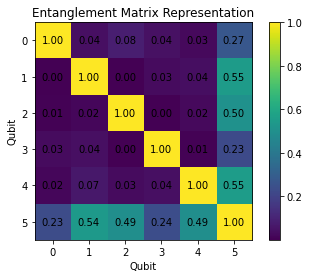

In [7]:
# Calcualte the entanglement matrix for the previous circuit.

fig, ax = plt.subplots()

matrix = ent_matrix(qc, 1000)
im = ax.imshow(matrix)
ax.set_title("Entanglement Matrix Representation")
ax.set_xlabel("Qubit")
ax.set_ylabel("Qubit")
fig.colorbar(im)

for (j,i),label in np.ndenumerate(matrix):
    plt.text(i,j,"%.2f" % label,ha='center',va='center')
    #plt.text(i,j,label,ha='center',va='center')

plt.show()

As you can see the circuit has a more entanglement in the qubit pairs: 
* [5,1]
* [5,2]
* [5,4]   

Compare to the others.

## Fully connected architecture

For the QFA only the important qubits to be measure are the last one that reference to the results of the sum.  
Now, lets simulate the perfect behaviour of the circuit.

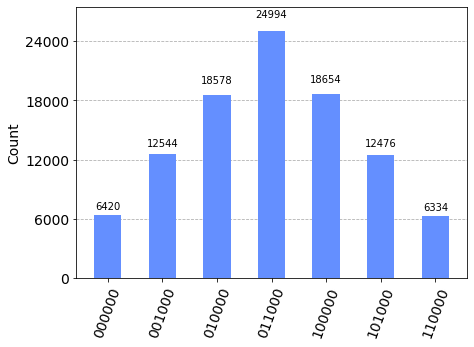

In [8]:
# Perfect results:
shots = 100000
qc.measure([3,4,5],[3,4,5])
Simulation = Aer.get_backend('qasm_simulator')
Quantum_Transpiler = transpile(qc,Simulation)
Quantum_Obj = assemble(Quantum_Transpiler, shots=shots)
real_dict = Simulation.run(Quantum_Obj).result().get_counts()

plot_histogram(real_dict)

## Fully connected architecture with noise 

Lets apply some noise to evaluate the performance of the error compare to the fully connected.  
This code is based on the qiskit noise models: https://qiskit.org/ecosystem/aer/tutorials/3_building_noise_models.html

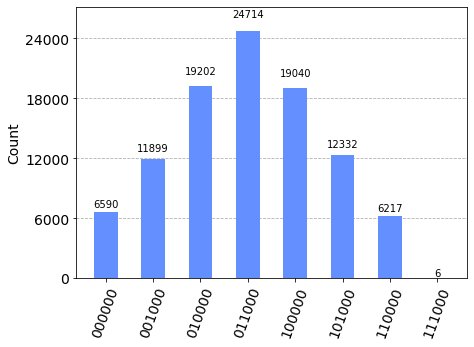

In [9]:
# Nosie results:
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error
# T1 and T2 values for qubits 0-3
T1s = np.random.normal(70e3, 10e3, 4) # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(50e3, 10e3, 4)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

# Instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100 # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

# Run the noisy simulation
sim_thermal = AerSimulator(noise_model=noise_thermal, shots=shots)

# Transpile circuit for noisy basis gates
circ_tthermal = transpile(qc, sim_thermal)

# Run and get counts
result_thermal = sim_thermal.run(circ_tthermal).result()
counts_thermal = result_thermal.get_counts(0)

# Plot noisy output
plot_histogram(counts_thermal)

In [10]:
err = error(real_dict, counts_thermal, shots)
print("--------------------------")
print("          Error           ")
print("--------------------------")
print("Error for fully connected with noise: {}%".format(err*100))

--------------------------
          Error           
--------------------------
Error for fully connected with noise: 2.3720000000000003%


## Linear architecture with noise 
Now, we need to take into account the physical connected qubits. Lets suppose a linear architecture.

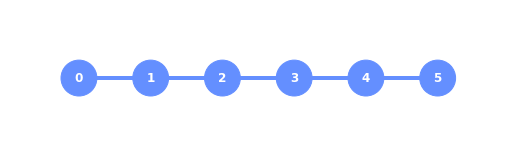

In [11]:
# Description of architecture
plot_coupling_map(6,[[0,0],[0,1],[0,2],[0,3],[0,4],[0,5]],[[0,1],[1,2],[2,3],[3,4],[4,5]])

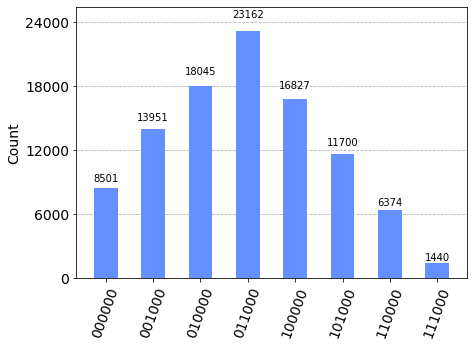

In [12]:
### Noise + Hardware constrains

sim_thermal = AerSimulator(noise_model=noise_thermal, shots=shots)
circ_tthermal = transpile(qc, sim_thermal, coupling_map=[[0,1],[1,2],[2,3],[3,4],[4,5]])
result_thermal = sim_thermal.run(circ_tthermal).result()
counts_thermal_constrains = result_thermal.get_counts(0)

plot_histogram(counts_thermal_constrains)

In [13]:
err_linear = error(real_dict, counts_thermal_constrains, shots)
print("--------------------------")
print("          Error           ")
print("--------------------------")
print("Error for fully connected with noise: {}%".format(err*100))
print("Error for linear architecture with noise: {}%".format(err_linear*100))

--------------------------
          Error           
--------------------------
Error for fully connected with noise: 2.3720000000000003%
Error for linear architecture with noise: 9.936%


## Honney architecture with noise
As we will define later the honney architecture will be the selected over the others ones.

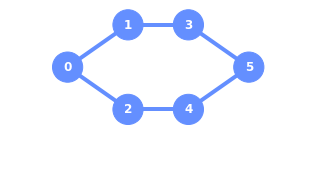

In [14]:
plot_coupling_map(6,[[0,0],[-0.7,1],[0.7,1],[-0.7,2],[0.7,2],[0,3]],[[0,1],[0,2],[1,3],[2,4],[3,5],[4,5]])

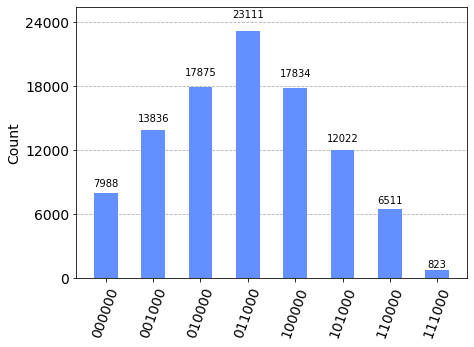

In [15]:
### Noise + Hardware constrains

sim_thermal = AerSimulator(noise_model=noise_thermal, shots=shots)
circ_tthermal = transpile(qc, sim_thermal, coupling_map=[[0,1],[0,2],[1,3],[2,4],[3,5],[4,5]])
result_thermal = sim_thermal.run(circ_tthermal).result()
counts_thermal_constrains_honney = result_thermal.get_counts(0)

plot_histogram(counts_thermal_constrains_honney)

In [16]:
err_honney = error(real_dict, counts_thermal_constrains_honney, shots)
print("--------------------------")
print("          Error           ")
print("--------------------------")
print("Error for fully connected with noise: {}%".format(err*100))
print("Error for linear architecture with noise: {}%".format(err_linear*100))
print("Error for honney architecture with noise: {}%".format(err_honney*100))

--------------------------
          Error           
--------------------------
Error for fully connected with noise: 2.3720000000000003%
Error for linear architecture with noise: 9.936%
Error for honney architecture with noise: 7.720000000000001%


## Linear architecture + entanglement + noise
Now we will connect the qubits close to those that has more entanglement in the circuit design based on the matrix above.

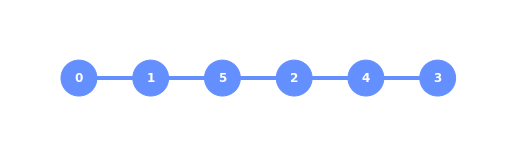

In [17]:
# Description of architecture
plot_coupling_map(6,[[0,0],[0,1],[0,3],[0,5],[0,4],[0,2]],[[0,1],[1,5],[5,2],[2,4],[4,3]])

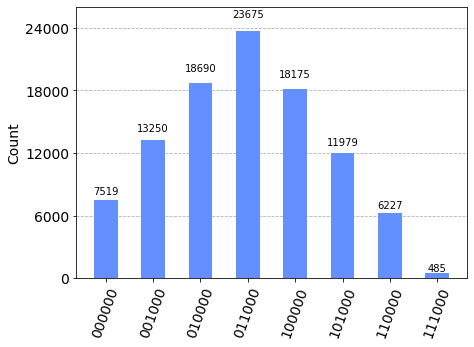

In [18]:
### Noise + Hardware constrains + Entanglement
sim_thermal = AerSimulator(noise_model=noise_thermal, shots = shots)
circ_tthermal = transpile(qc, sim_thermal, coupling_map=[[0,1],[1,5],[5,2],[2,4],[4,3]])
result_thermal = sim_thermal.run(circ_tthermal).result()
counts_thermal_ent = result_thermal.get_counts(0)

plot_histogram(counts_thermal_ent)

In [19]:
err_linear_ent = error(real_dict, counts_thermal_ent, shots)
print("--------------------------")
print("          Error           ")
print("--------------------------")
print("Error for fully connected with noise: {}%".format(err*100))
print("Error for linear architecture with noise: {}%".format(err_linear*100))
print("Error for honney architecture with noise: {}%".format(err_honney*100))
print("Error for linear architecture + entanglement + noise: {}%".format(err_linear_ent*100))

--------------------------
          Error           
--------------------------
Error for fully connected with noise: 2.3720000000000003%
Error for linear architecture with noise: 9.936%
Error for honney architecture with noise: 7.720000000000001%
Error for linear architecture + entanglement + noise: 4.804%


## Honney architecture + entanglement + noise

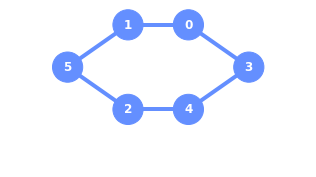

In [20]:
# Description of architecture
#plot_coupling_map(6,[[0.7,2],[-0.7,1],[0.7,1],[0,3],[-0.7,2],[0,0]],[[5,1],[1,0],[5,2],[4,3],[3,0],[2,4]])
plot_coupling_map(6,[[-0.7,2],[-0.7,1],[0.7,1],[0,3],[0.7,2],[0,0]],[[5,1],[1,0],[5,2],[4,3],[3,0],[2,4]])

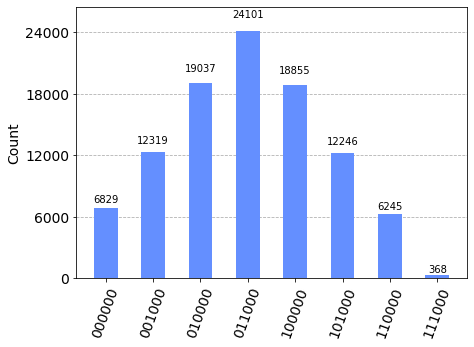

In [21]:
### Noise + Hardware constrains + Entanglement
sim_thermal = AerSimulator(noise_model=noise_thermal, shots = shots)
circ_tthermal = transpile(qc, sim_thermal, coupling_map=[[5,1],[1,0],[5,2],[4,3],[3,0],[2,4]])
result_thermal = sim_thermal.run(circ_tthermal).result()
counts_thermal_honney_ent = result_thermal.get_counts(0)

plot_histogram(counts_thermal_honney_ent)

In [22]:
## For 10000 shots
err_honney_ent = error(real_dict, counts_thermal_honney_ent, shots)
print("--------------------------")
print("          Error           ")
print("--------------------------")
print("Error for fully connected with noise: {}%".format(err*100))
print("Error for linear architecture with noise: {}%".format(err_linear*100))
print("Error for honney architecture with noise: {}%".format(err_honney*100))
print("Error for linear architecture + entanglement + noise: {}%".format(err_linear_ent*100))
print("Error for honney architecture + entanglement + noise: {}%".format(err_honney_ent*100))

--------------------------
          Error           
--------------------------
Error for fully connected with noise: 2.3720000000000003%
Error for linear architecture with noise: 9.936%
Error for honney architecture with noise: 7.720000000000001%
Error for linear architecture + entanglement + noise: 4.804%
Error for honney architecture + entanglement + noise: 2.874%


## So, always remember to take into account the entanglement of the circuit qubit by qubit!